In [1]:
import laspy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric

import src.visualization.clouds

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport src.visualization.clouds

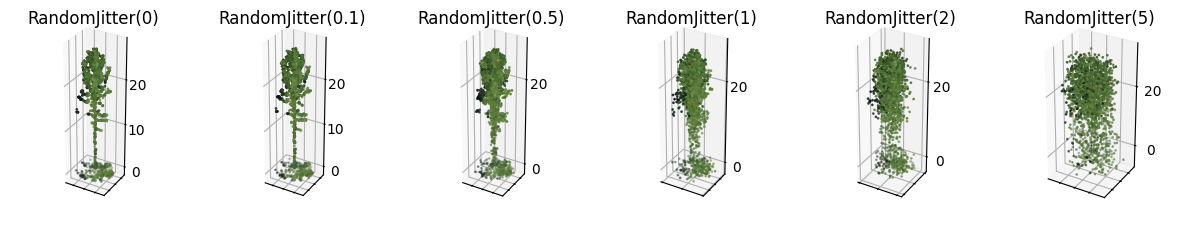

In [4]:
#| include: true
#| label: fig-random-jitter-effect
#| fig-cap: Visualization of the random jitter augmentation on a single birch tree.

las = laspy.read("../../data/interim/trees/birch_09.las")

means = las.xyz.mean(axis=0, keepdims=True)
means[0][-1] = 0  # Don't recenter Z

rgb = np.transpose(np.stack([las.red, las.green, las.blue])) / 255

data = torch_geometric.data.Data(
    pos=torch.from_numpy(las.xyz - means),
    x=torch.from_numpy(rgb),
)

fig = plt.figure(figsize=(15, 10))

params = [0, 0.1, 0.5, 1, 2, 5]

for i, x in enumerate(params, start=1):
    ax = fig.add_subplot(1, len(params), i, projection="3d")
    transformed = torch_geometric.transforms.RandomJitter(x)(data)
    ax = src.visualization.clouds.scatter_point_cloud_3d(
        xyz=transformed.pos.numpy(),
        color=rgb,
        ax=ax,
    )
    ax.set_title(f"RandomJitter({x})")
    ax.set_aspect("equal")
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())